In [1]:
import numpy as np
import pandas as pd

from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.layers import Dropout, BatchNormalization 
from tensorflow.keras.utils import to_categorical

from keras.callbacks import ModelCheckpoint

import matplotlib.pyplot as plt

import seaborn as sns
import os
import glob
import plotly.graph_objects as go
import cv2
from PIL import Image
from PIL import ImageFile
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.applications.vgg16 import VGG16
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau,ModelCheckpoint 
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import warnings
warnings.filterwarnings("ignore")
ImageFile.LOAD_TRUNCATED_IMAGES = True

from tqdm import tqdm

# 데이터

In [2]:
label = pd.read_csv("../input/intel-mobileodt-cervical-cancer-screening/fixed_labels_v2.csv")
label

,filename,old_label,new_label
0,10.jpg,Type_2,Type_1
1,1001.jpg,Type_2,Type_1
2,1002.jpg,Type_3,Type_2
3,1004.jpg,Type_2,Type_1
4,1005.jpg,Type_3,Type_1
...,...,...,...
1816,975.jpg,Type_2,Type_1
1817,984.jpg,Type_2,Type_3
1818,986.jpg,Type_2,Type_1
1819,988.jpg,Type_2,Type_1


In [3]:
root_dir = '../input/intel-mobileodt-cervical-cancer-screening'
train_dir = os.path.join(root_dir,'train', 'train')

type1_dir = os.path.join(train_dir, 'Type_1')
type2_dir = os.path.join(train_dir, 'Type_2')
type3_dir = os.path.join(train_dir, 'Type_3')

train_type1_files = glob.glob(type1_dir+'/*.jpg')
train_type2_files = glob.glob(type2_dir+'/*.jpg')
train_type3_files = glob.glob(type3_dir+'/*.jpg')

added_type1_files  =  glob.glob(os.path.join(root_dir, "additional_Type_1_v2", "Type_1")+'/*.jpg')
added_type2_files  =  glob.glob(os.path.join(root_dir, "additional_Type_2_v2", "Type_2")+'/*.jpg')
added_type3_files  =  glob.glob(os.path.join(root_dir, "additional_Type_3_v2", "Type_3")+'/*.jpg')


type1_files = train_type1_files + added_type1_files
type2_files = train_type2_files + added_type2_files
type3_files = train_type3_files + added_type3_files

print(f'''Type 1 files for training: {len(type1_files)} 
Type 2 files for training: {len(type2_files)}
Type 3 files for training: {len(type3_files)}''' )

Type 1 files for training: 1441 
Type 2 files for training: 4348
Type 3 files for training: 2426


In [4]:
files = {'filepath': type1_files + type2_files + type3_files,
          'label': ['Type 1']* len(type1_files) + ['Type 2']* len(type2_files) + ['Type 3']* len(type3_files)}

files_df = pd.DataFrame(files).sample(frac=1, random_state= 1).reset_index(drop=True)
files_df

,filepath,label
0,../input/intel-mobileodt-cervical-cancer-scree...,Type 1
1,../input/intel-mobileodt-cervical-cancer-scree...,Type 3
2,../input/intel-mobileodt-cervical-cancer-scree...,Type 1
3,../input/intel-mobileodt-cervical-cancer-scree...,Type 2
4,../input/intel-mobileodt-cervical-cancer-scree...,Type 3
...,...,...
8210,../input/intel-mobileodt-cervical-cancer-scree...,Type 2
8211,../input/intel-mobileodt-cervical-cancer-scree...,Type 3
8212,../input/intel-mobileodt-cervical-cancer-scree...,Type 1
8213,../input/intel-mobileodt-cervical-cancer-scree...,Type 2


In [5]:
bad_files = []
for path in tqdm(files_df['filepath'].values):
    try:
        img = Image.open(path)
    except:
        index = files_df[files_df['filepath']==path].index.values[0]
        bad_files.append(index)

100%|██████████| 8215/8215 [01:54<00:00, 71.87it/s]


In [6]:
bad_files
files_df.drop(bad_files, inplace=True)

In [7]:
# save csv (files_df)
#files_df.to_csv('/kaggle/working/dropfiles.csv', sep=',')

In [8]:
# 정리된 files_df 사용
#files_df = pd.read_csv('../input/cervical-dropfiles/dropfiles.csv', sep=',').drop('Unnamed: 0', axis=1)
#files_df

In [9]:
# get count of each type 
type_count = pd.DataFrame(files_df['label'].value_counts()).rename(columns= {'label': 'Num_Values'})
type_count

,Num_Values
Type 2,4346
Type 3,2426
Type 1,1440


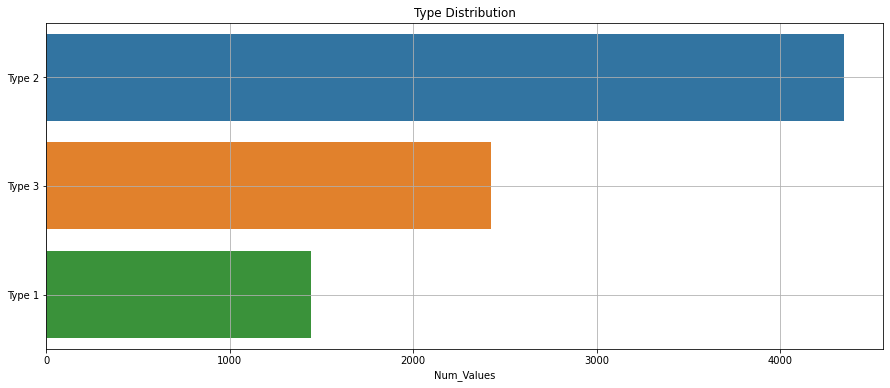

In [10]:
plt.figure(figsize = (15, 6))
sns.barplot(x= type_count['Num_Values'], y= type_count.index.to_list())
plt.title('Type Distribution')
plt.grid(True)
plt.show()

In [11]:
pie_plot = go.Pie(labels= type_count.index.to_list(), values= type_count.values.flatten(),
                 hole= 0.2, text= type_count.index.to_list(), textposition='auto')
fig = go.Figure([pie_plot])
fig.update_layout(title_text='Pie Chart of Type Distribution')
fig.show()

# 데이터 분리

In [12]:
# Train / Validation

train_df, valid_df = train_test_split(files_df, test_size = 0.2, stratify = files_df['label'], random_state = 1234)

print(len(train_df), len(valid_df))

6569 1643


In [13]:
X_train = train_df[['filepath']]
y_train = train_df[['label']]
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

In [14]:
X_valid = valid_df[['filepath']].reset_index(drop=True)
y_valid = valid_df[['label']].reset_index(drop=True)

print(len(X_train), len(y_train), len(X_valid),len(y_valid))

6569 6569 1643 1643


# 데이터 전처리

In [15]:
# train data

features = []
f_app = features.append
path = train_df['filepath'].values
labels = train_df['label'].values
for p in tqdm(path):
    image = cv2.imread(p)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    re_image = cv2.resize(image, (25,25))
    f_app(np.array(re_image))

X_train = np.array(features)
y_train = np.array(labels)

100%|██████████| 6569/6569 [22:25<00:00,  4.88it/s]


In [16]:
# save train data as npy files

#np.save('/kaggle/working/X_train_25', X_train)
#np.save('/kaggle/working/y_train_25', y_train)

In [17]:
# 소요시간줄이는코드 (추가 수정 필요)
#path = train_df['filepath'].values
#labels = train_df['label'].values
#features = [np.array(cv2.resize(cv2.cvtColor(cv2.imread(p),cv2.COLOR_RGB2BGR),(180,180))) for p in tqdm(path)]

In [18]:
# validation data

features = []
f_app = features.append
path = valid_df['filepath'].values
labels = valid_df['label'].values
for p in tqdm(path):
    image = cv2.imread(p)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    re_image = cv2.resize(image, (25,25))
    f_app(np.array(re_image))

X_valid = np.array(features)
y_valid = np.array(labels)

100%|██████████| 1643/1643 [05:38<00:00,  4.85it/s]


In [19]:
# save validation data as npy files

#np.save('/kaggle/working/X_valid_25', X_valid)
#np.save('/kaggle/working/y_valid_25', y_valid)

In [20]:
# X train data 확인
X_train[0]

array([[[108, 115, 121],
        [127, 145, 155],
        [125, 126, 144],
        ...,
        [127,  85, 131],
        [104,  67, 104],
        [101,  66,  99]],

       [[115, 114, 120],
        [129, 121, 142],
        [117, 109, 130],
        ...,
        [114,  73, 105],
        [100,  61,  92],
        [ 92,  62,  90]],

       [[126, 108, 127],
        [127, 100, 125],
        [125,  97, 118],
        ...,
        [148, 101, 143],
        [138,  94, 130],
        [116,  76, 112]],

       ...,

       [[ 43,  18,  30],
        [ 49,  19,  26],
        [ 58,  25,  34],
        ...,
        [146,  97, 129],
        [142,  95, 139],
        [119,  80, 121]],

       [[ 43,  26,  36],
        [ 47,  27,  38],
        [ 52,  21,  36],
        ...,
        [139, 101, 140],
        [140, 114, 153],
        [108,  70, 107]],

       [[ 62,  41,  56],
        [ 43,  23,  35],
        [ 41,  21,  32],
        ...,
        [ 89,  60,  78],
        [109,  76,  93],
        [ 71,  40,  46]]

In [21]:
# X validation data 확인
X_valid[0]

array([[[ 72,  60,  80],
        [ 77,  63,  85],
        [ 80,  66,  91],
        ...,
        [ 70,  73, 108],
        [ 42,  63,  92],
        [ 24,  39,  54]],

       [[112,  87, 116],
        [108,  84, 114],
        [109,  84, 116],
        ...,
        [ 86,  75, 118],
        [ 69,  77, 113],
        [ 32,  54,  78]],

       [[136, 103, 134],
        [129,  88, 122],
        [141, 101, 137],
        ...,
        [103,  81, 128],
        [ 96,  84, 132],
        [ 64,  73, 109]],

       ...,

       [[121, 108, 133],
        [127, 113, 139],
        [150, 125, 155],
        ...,
        [ 29,  17,  27],
        [ 27,  15,  27],
        [143, 102, 144]],

       [[130, 104, 126],
        [146, 122, 147],
        [140, 107, 134],
        ...,
        [157, 110, 150],
        [171, 130, 174],
        [150, 115, 157]],

       [[115, 103, 127],
        [142, 117, 143],
        [153, 129, 153],
        ...,
        [157, 122, 164],
        [129, 105, 143],
        [ 64,  50,  75]]

In [22]:
# 정규화 (0과1사이의값)
X_train = X_train/255
X_valid = X_valid/255

In [23]:
# 정규화한 X train data 확인
X_train[0]

array([[[0.42352941, 0.45098039, 0.4745098 ],
        [0.49803922, 0.56862745, 0.60784314],
        [0.49019608, 0.49411765, 0.56470588],
        ...,
        [0.49803922, 0.33333333, 0.51372549],
        [0.40784314, 0.2627451 , 0.40784314],
        [0.39607843, 0.25882353, 0.38823529]],

       [[0.45098039, 0.44705882, 0.47058824],
        [0.50588235, 0.4745098 , 0.55686275],
        [0.45882353, 0.42745098, 0.50980392],
        ...,
        [0.44705882, 0.28627451, 0.41176471],
        [0.39215686, 0.23921569, 0.36078431],
        [0.36078431, 0.24313725, 0.35294118]],

       [[0.49411765, 0.42352941, 0.49803922],
        [0.49803922, 0.39215686, 0.49019608],
        [0.49019608, 0.38039216, 0.4627451 ],
        ...,
        [0.58039216, 0.39607843, 0.56078431],
        [0.54117647, 0.36862745, 0.50980392],
        [0.45490196, 0.29803922, 0.43921569]],

       ...,

       [[0.16862745, 0.07058824, 0.11764706],
        [0.19215686, 0.0745098 , 0.10196078],
        [0.22745098, 0

In [24]:
# 정규화한 X validation data 확인
X_valid[0]

array([[[0.28235294, 0.23529412, 0.31372549],
        [0.30196078, 0.24705882, 0.33333333],
        [0.31372549, 0.25882353, 0.35686275],
        ...,
        [0.2745098 , 0.28627451, 0.42352941],
        [0.16470588, 0.24705882, 0.36078431],
        [0.09411765, 0.15294118, 0.21176471]],

       [[0.43921569, 0.34117647, 0.45490196],
        [0.42352941, 0.32941176, 0.44705882],
        [0.42745098, 0.32941176, 0.45490196],
        ...,
        [0.3372549 , 0.29411765, 0.4627451 ],
        [0.27058824, 0.30196078, 0.44313725],
        [0.1254902 , 0.21176471, 0.30588235]],

       [[0.53333333, 0.40392157, 0.5254902 ],
        [0.50588235, 0.34509804, 0.47843137],
        [0.55294118, 0.39607843, 0.5372549 ],
        ...,
        [0.40392157, 0.31764706, 0.50196078],
        [0.37647059, 0.32941176, 0.51764706],
        [0.25098039, 0.28627451, 0.42745098]],

       ...,

       [[0.4745098 , 0.42352941, 0.52156863],
        [0.49803922, 0.44313725, 0.54509804],
        [0.58823529, 0

In [25]:
# train 개수, 차원 확인
print(len(X_train), len(y_train))
print(X_train.shape)

6569 6569
(6569, 25, 25, 3)


In [26]:
# validation 개수, 차원 확인
print(len(X_valid), len(y_valid))
print(X_valid.shape)

1643 1643
(1643, 25, 25, 3)


In [27]:
# y 라벨링 (string -> int)
le = LabelEncoder().fit(['Type 1', 'Type 2', 'Type 3'])
y_train = le.transform(y_train)
y_valid = le.transform(y_valid)

y_train_onehot = to_categorical(y_train, num_classes=3)
y_valid_onehot = to_categorical(y_valid, num_classes=3)

In [28]:
y_train_onehot[:5]

array([[0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.]], dtype=float32)

In [29]:
y_valid_onehot[:5]

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.]], dtype=float32)

In [30]:
# simple DNN

simDNN = Sequential([
    Flatten()
    , Dense(128, activation = 'relu')
    , Dense(3, activation = 'softmax')
])

simDNN.compile(
    optimizer = 'adam'
    , loss = 'categorical_crossentropy'
    , metrics = ['accuracy']
)

history_1 = simDNN.fit(
    X_train, y_train_onehot
    , epochs = 15
    , batch_size = 128
    , verbose = 1
    , validation_split = 0.25
)

2022-11-13 07:43:49.048880: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-13 07:43:49.151215: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-13 07:43:49.151989: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-13 07:43:49.162210: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Epoch 1/15
39/39 [==============================] - 2s 8ms/step - loss: 1.0912 - accuracy: 0.4886 - val_loss: 0.9840 - val_accuracy: 0.5326
Epoch 2/15
39/39 [==============================] - 0s 4ms/step - loss: 0.9783 - accuracy: 0.5311 - val_loss: 0.9835 - val_accuracy: 0.5253
Epoch 3/15
39/39 [==============================] - 0s 4ms/step - loss: 0.9743 - accuracy: 0.5278 - val_loss: 0.9519 - val_accuracy: 0.5423
Epoch 4/15
39/39 [==============================] - 0s 3ms/step - loss: 0.9525 - accuracy: 0.5434 - val_loss: 0.9613 - val_accuracy: 0.5350
Epoch 5/15
39/39 [==============================] - 0s 3ms/step - loss: 0.9548 - accuracy: 0.5418 - val_loss: 0.9447 - val_accuracy: 0.5350
Epoch 6/15
39/39 [==============================] - 0s 3ms/step - loss: 0.9474 - accuracy: 0.5497 - val_loss: 0.9403 - val_accuracy: 0.5551
Epoch 7/15
39/39 [==============================] - 0s 4ms/step - loss: 0.9415 - accuracy: 0.5471 - val_loss: 0.9367 - val_accuracy: 0.5484
Epoch 8/15
39/39 [==

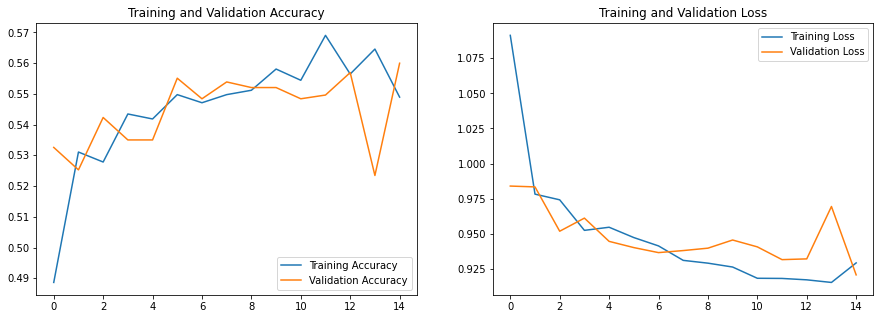

In [31]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(history_1.history['accuracy'], label='Training Accuracy')
plt.plot(history_1.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history_1.history['loss'], label='Training Loss')
plt.plot(history_1.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

In [32]:
# simple CNN

simCNN = Sequential([
  keras.Input(shape=(25,25,3))
  , Conv2D(filters = 15, kernel_size = (2,2), padding='same')
  , BatchNormalization()
  , Activation('relu')
  , MaxPooling2D(pool_size=2)
  , Flatten()
  , Dense(10)
  , Activation('relu')
  , Dense(3, activation='softmax')
])

simCNN.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 25, 25, 15)        195       
_________________________________________________________________
batch_normalization (BatchNo (None, 25, 25, 15)        60        
_________________________________________________________________
activation (Activation)      (None, 25, 25, 15)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 15)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2160)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                21610     
_________________________________________________________________
activation_1 (Activation)    (None, 10)               

In [33]:
simCNN.compile(
  'adam'
  , loss='categorical_crossentropy'
  , metrics=['accuracy']
)

history_2 = simCNN.fit(
        x=X_train, y=y_train_onehot
        , epochs=15
        , validation_data=(X_valid, y_valid_onehot)
        , verbose=1
        , batch_size=128
)

2022-11-13 07:43:59.380340: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 49267500 exceeds 10% of free system memory.
2022-11-13 07:43:59.457807: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 49267500 exceeds 10% of free system memory.


Epoch 1/15


2022-11-13 07:44:00.582723: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


52/52 [==============================] - 6s 8ms/step - loss: 0.9916 - accuracy: 0.5147 - val_loss: 1.0189 - val_accuracy: 0.5295
Epoch 2/15
52/52 [==============================] - 0s 4ms/step - loss: 0.9390 - accuracy: 0.5448 - val_loss: 1.0109 - val_accuracy: 0.5514
Epoch 3/15
52/52 [==============================] - 0s 4ms/step - loss: 0.9147 - accuracy: 0.5532 - val_loss: 0.9874 - val_accuracy: 0.5350
Epoch 4/15
52/52 [==============================] - 0s 4ms/step - loss: 0.9142 - accuracy: 0.5485 - val_loss: 0.9546 - val_accuracy: 0.5514
Epoch 5/15
52/52 [==============================] - 0s 4ms/step - loss: 0.8933 - accuracy: 0.5590 - val_loss: 0.9492 - val_accuracy: 0.5490
Epoch 6/15
52/52 [==============================] - 0s 4ms/step - loss: 0.8778 - accuracy: 0.5706 - val_loss: 0.9278 - val_accuracy: 0.5581
Epoch 7/15
52/52 [==============================] - 0s 4ms/step - loss: 0.8656 - accuracy: 0.5733 - val_loss: 0.9146 - val_accuracy: 0.5526
Epoch 8/15
52/52 [=============

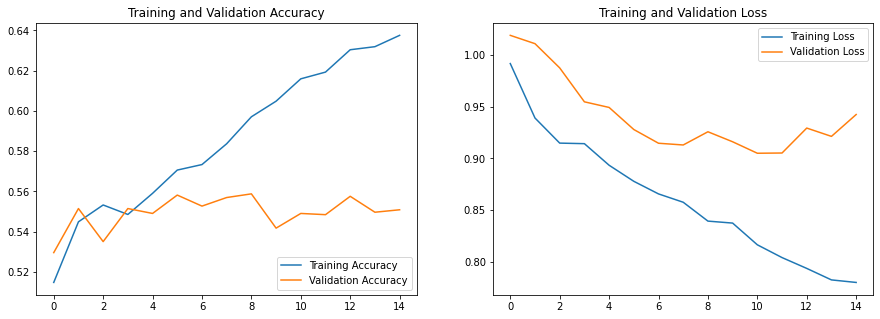

In [34]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(history_2.history['accuracy'], label='Training Accuracy')
plt.plot(history_2.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history_2.history['loss'], label='Training Loss')
plt.plot(history_2.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

# 원선님 모델

In [35]:
dnn = Sequential([
    keras.Input(shape=(25, 25, 3)),
    Flatten(),
    Dense(256, activation='relu'),
    #Dense(50),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')
])

dnn.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 1875)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               480256    
_________________________________________________________________
dense_5 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_6 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_7 (Dense)              (None, 3)                 195       
Total params: 521,603
Trainable params: 521,603
Non-trainable params: 0
_________________________________________________________________


In [36]:
dnn.compile(
    'adam',
  loss='categorical_crossentropy',
  metrics=['accuracy'],
)

historydnn =dnn.fit(
        x=X_train,y=y_train_onehot, 
        epochs=15, 
        validation_data=(X_valid, y_valid_onehot),
        verbose=1,
        batch_size=128
)

2022-11-13 07:44:13.293874: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 49267500 exceeds 10% of free system memory.


Epoch 1/15
52/52 [==============================] - 1s 6ms/step - loss: 1.0100 - accuracy: 0.5202 - val_loss: 0.9608 - val_accuracy: 0.5307
Epoch 2/15
52/52 [==============================] - 0s 3ms/step - loss: 0.9696 - accuracy: 0.5322 - val_loss: 0.9691 - val_accuracy: 0.5460
Epoch 3/15
52/52 [==============================] - 0s 4ms/step - loss: 0.9584 - accuracy: 0.5345 - val_loss: 0.9742 - val_accuracy: 0.5460
Epoch 4/15
52/52 [==============================] - 0s 4ms/step - loss: 0.9467 - accuracy: 0.5374 - val_loss: 0.9418 - val_accuracy: 0.5520
Epoch 5/15
52/52 [==============================] - 0s 3ms/step - loss: 0.9489 - accuracy: 0.5432 - val_loss: 0.9259 - val_accuracy: 0.5673
Epoch 6/15
52/52 [==============================] - 0s 3ms/step - loss: 0.9362 - accuracy: 0.5441 - val_loss: 0.9452 - val_accuracy: 0.5630
Epoch 7/15
52/52 [==============================] - 0s 4ms/step - loss: 0.9372 - accuracy: 0.5457 - val_loss: 0.9199 - val_accuracy: 0.5752
Epoch 8/15
52/52 [==

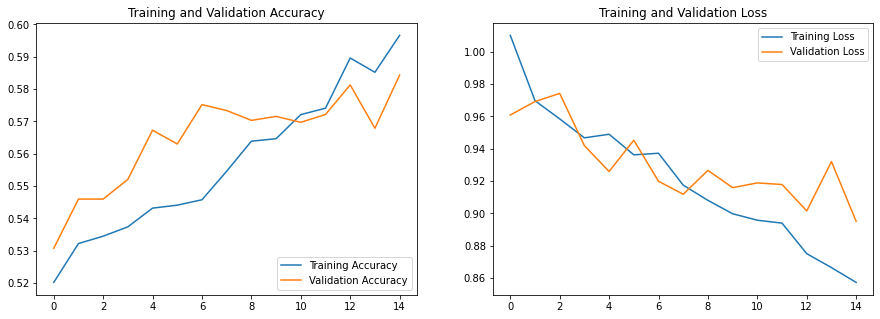

In [37]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(historydnn.history['accuracy'], label='Training Accuracy')
plt.plot(historydnn.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(historydnn.history['loss'], label='Training Loss')
plt.plot(historydnn.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

In [38]:
cnn = Sequential([
    keras.Input(shape=(25, 25, 3)),
    
    Conv2D(64, kernel_size = (3,3), padding='same', kernel_initializer='random_normal'),
    Activation('relu'),
    MaxPooling2D(pool_size=(2,2)),
    
    Conv2D(32, kernel_size = (3,3), padding='same', kernel_initializer='random_normal'),
    Activation('relu'),
    MaxPooling2D(pool_size=(2,2)),
    
    Conv2D(64, kernel_size = (3,3), padding='same', kernel_initializer='random_normal'),
    Activation('relu'),
    MaxPooling2D(pool_size=(2,2)),

    Flatten(),
    Dense(64, kernel_initializer='random_normal'),
    Activation('relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
    
])

cnn.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 25, 25, 64)        1792      
_________________________________________________________________
activation_2 (Activation)    (None, 25, 25, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 32)        18464     
_________________________________________________________________
activation_3 (Activation)    (None, 12, 12, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 6, 6, 64)         

In [39]:
cnn.compile(
    'adam',
  loss='categorical_crossentropy',
  metrics=['accuracy'],
)

historycnn = cnn.fit(x=X_train,y=y_train_onehot, 
          epochs=15, 
          validation_data=(X_valid, y_valid_onehot),
          verbose=1,
          batch_size=128, 
)

Epoch 1/15
52/52 [==============================] - 1s 10ms/step - loss: 1.0150 - accuracy: 0.5156 - val_loss: 0.9836 - val_accuracy: 0.5301
Epoch 2/15
52/52 [==============================] - 0s 6ms/step - loss: 0.9951 - accuracy: 0.5281 - val_loss: 0.9710 - val_accuracy: 0.5460
Epoch 3/15
52/52 [==============================] - 0s 5ms/step - loss: 0.9788 - accuracy: 0.5340 - val_loss: 0.9586 - val_accuracy: 0.5502
Epoch 4/15
52/52 [==============================] - 0s 5ms/step - loss: 0.9707 - accuracy: 0.5340 - val_loss: 0.9475 - val_accuracy: 0.5466
Epoch 5/15
52/52 [==============================] - 0s 6ms/step - loss: 0.9620 - accuracy: 0.5333 - val_loss: 0.9423 - val_accuracy: 0.5460
Epoch 6/15
52/52 [==============================] - 0s 6ms/step - loss: 0.9474 - accuracy: 0.5352 - val_loss: 0.9418 - val_accuracy: 0.5545
Epoch 7/15
52/52 [==============================] - 0s 6ms/step - loss: 0.9267 - accuracy: 0.5470 - val_loss: 0.9264 - val_accuracy: 0.5600
Epoch 8/15
52/52 [=

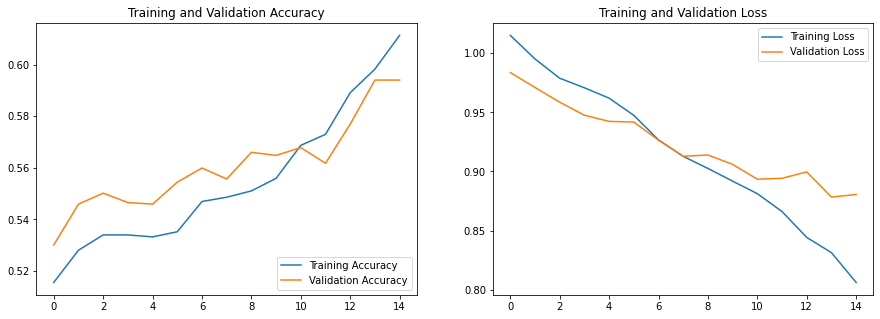

In [40]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(historycnn.history['accuracy'], label='Training Accuracy')
plt.plot(historycnn.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(historycnn.history['loss'], label='Training Loss')
plt.plot(historycnn.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

In [41]:
#이미지 오류남

#stage1 = y_train[y_train == 0].index
#stage2 = y_train[y_train == 1].index
#stage3 = y_train[y_train == 2].index

#

#stage1 = np.where(y_train == 0)
#type(stage1)
#stageq = stage1[0]

#stage2 = np.where(y_train == 1)
#type(stage2)
#stagew = stage2[0]

#stage3 = np.where(y_train == 2)
#type(stage3)
#stagee = stage3[0]

#

#plt.figure(figsize=(20, 20))

#for i in range(16):
#    plt.subplot(4, 4, i+1)
#    plt.suptitle('Type1 Images', fontsize=20) # 하나의 큰 제목 설정
#    plt.imshow(X_train[stageq[i]])
#    plt.title('Type1')
#    plt.subplots_adjust(hspace=0.5)
#    plt.axis(False)
#plt.show()

#

#plt.figure(figsize=(20, 20))

#for i in range(16):
#    plt.subplot(4, 4, i+1)
#    plt.suptitle('type2 Images', fontsize=20) # 하나의 큰 제목 설정
#    plt.imshow(X_train[stagew[i]])
#    plt.title('type2')
#    plt.subplots_adjust(hspace=0.5)
#    plt.axis(False)
#plt.savefig('type2.png', dpi=300)
#plt.show()

#

#plt.figure(figsize=(20, 20))
#
#for i in range(16):
#    plt.subplot(4, 4, i+1)
#    plt.suptitle('type3 Images', fontsize=20) # 하나의 큰 제목 설정
#    plt.imshow(X_train[stagee[i]])
#    plt.title('type3')
#    plt.subplots_adjust(hspace=0.5)
#    plt.axis(False)
#plt.savefig('type3.png', dpi=300)
#plt.show()

In [42]:
# 참고용
# double

#history_df_cnn = pd.DataFrame(historycnn.history)
#history_df_dnn = pd.DataFrame(historydnn.history)

#plt.figure(figsize= (15,6))
#plt.subplot(1,2,1)
#plt.plot(history_df_cnn['accuracy'], label= 'cnn_accuracy' )
## plt.plot(history_df_cnn['val_accuracy'], label= 'val_accuracy')
#plt.plot(history_df_dnn['accuracy'], label= 'dnn_accuracy', color='limegreen' )
## plt.plot(history_df_dnn['val_accuracy'], label= 'val_accuracy', color='limegreen')
## history_df[['acc', 'val_acc']]
#plt.xlabel('Epochs')
#plt.ylabel('Accuracy')
#plt.title('Training and Validation Accuracy History')
#plt.legend()

# display history of loss
#plt.subplot(1,2,2)
#plt.plot(history_df_cnn['loss'], label= 'cnn_loss')
##plt.plot(history_df_cnn['val_loss'], label= 'val_loss')
#plt.plot(history_df_dnn['loss'], label= 'dnn_loss', color='limegreen')
##plt.plot(history_df_dnn['val_loss'], label= 'val_loss', color='limegreen')
# history_df[['loss', 'val_loss']].plot()
#plt.xlabel('Epochs')
#plt.ylabel('Loss')
#plt.title('Training and Validation Loss History')
#plt.legend()
#plt.savefig('fig2.png', dpi=300)
#plt.show()


In [43]:
#plt.figure(figsize= (6,6))
#plt.plot(history_df_cnn['accuracy'], label= 'cnn_accuracy' )
##plt.plot(history_df_cnn['val_loss'], label= 'val_loss')
##plt.plot(history_df_dnn['loss'], label= 'dnn_loss', color='limegreen')
##plt.plot(history_df_dnn['val_loss'], label= 'val_loss', color='limegreen')
## history_df[['loss', 'val_loss']].plot()
#plt.xlabel('Epochs')
#plt.ylabel('Loss')
#plt.title('Training and Validation Loss History')
#plt.legend()
#plt.savefig('cnnaccuracy.png', dpi=300)
#plt.show()

# test data (2차에 활용)

In [44]:
# test data

#test_y = pd.read_csv("../input/intel-mobileodt-cervical-cancer-screening/solution_stg1_release.csv")
#test_y.loc[1,['Type_1','Type_2','Type_3']]

#root_dir = '../input/intel-mobileodt-cervical-cancer-screening'
#test_dir = os.path.join(root_dir,'test', 'test')

#test_type = []
#test_features = []
#i=0
#for fn in test_y[['image_name']].to_numpy():
#    for filename in fn:
#        filepath = os.path.join(test_dir,filename)
#        #print(filepath)
#        img = cv2.imread(filepath)
#        resized_img = cv2.resize(img, (180, 180))
#        test_features.append(np.array(resized_img))
#        test_type.append(np.array(test_y.loc[i,['Type_1','Type_2','Type_3']]))
#        i=i+1
    
#print( len(test_features))

In [45]:
#test_y = pd.read_csv("../input/intel-mobileodt-cervical-cancer-screening/solution_stg1_release.csv")
#test_y.loc[1,['Type_1','Type_2','Type_3']]

In [46]:
#y_test = test_y.loc[:,['Type_1','Type_2','Type_3']]
#y_test
#import tensorflow as tf

In [47]:
#y_train_onehot

In [48]:
#print(y_test)
#list = []
#for d in y_test.index:
#    res = y_test.loc[d,:].values.tolist()
#    list.append(res)

In [49]:
#y_test = np.array(list)
#y_test

In [50]:
# normalize test features
#test_X = np.array(test_features)
#X_test = test_X/255

In [51]:
#print(cnn.evaluate(X_test, y_test))
#print(dnn.evaluate(X_test, y_test))